# TP4, INF8225 2025, Projet


## Imports

In [1]:
from IPython.display import clear_output

%pip install torch torchvision --index-url https://download.pytorch.org/whl/cu121
%pip install numpy
%pip install swig
%pip install box2d
%pip install pygame
%pip install gymnasium
%pip install "gymnasium[box2d]"
%pip install matplotlib
%pip install wandb

clear_output()

In [30]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.animation as animation
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import random
import os
import wandb
from IPython.display import clear_output
import math
from collections import namedtuple, deque

### Initialisation

In [31]:
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(torch.version.cuda)

if torch.cuda.is_available():
	print(torch.cuda.get_device_name(0))

True
12.1
NVIDIA GeForce GTX 1050


## Data Declaration

In [32]:
def show_animation(env):
	show_animation_frames(env.render())

def show_animation_frames(frames):
	fig = plt.figure(figsize=(7, 5))
	plt.axis('off')
	im = plt.imshow(frames[0])

	def animate(i):
		im.set_data(frames[i])
		return im,

	anim = animation.FuncAnimation(fig, animate, frames=len(frames), repeat=False)
	plt.close(fig)
	display(HTML(anim.to_jshtml()))

def show_current_frame(env, data):
	frame = env.render()
	fig, _ = plt.subplots()
	r = fig.canvas.get_renderer()
	plt.imshow(frame)
	plt.axis('off')
	texts = []
	size_used = 0
	for i, key in enumerate(data):
		title = f'{key}: {data[key]}'
		if type(data[key]) == float or type(data[key]) == torch.Tensor:
			title = f'{key}: {data[key]:.2f}'
		text = plt.text(0, 0, title, fontsize=12, color='black', backgroundcolor='white', ha="center")
		size_used += text.get_window_extent(renderer=r).width
		texts.append(text)
	split = (700 - size_used) / (len(data) + 1)
	next_position = split
	for t in texts:
		t.set_position((next_position, 0))
		next_position = next_position + t.get_window_extent(renderer=r).width + split
	clear_output(wait=True)
	plt.show()

def skip_zooming(env):
	no_action = 0
	if type(env.action_space) != gym.spaces.Discrete:
		no_action = np.zeros((env.action_space.shape[0]))

	for _ in range(50):
		observation, _, terminated, truncated, info = env.step(no_action)

		if terminated or truncated:
			observation, info = env.reset()
			break
	return observation, info

### Helper Function

In [33]:
transform = T.Compose([
	T.ToPILImage(),
	T.Grayscale(num_output_channels=1),
	T.Resize((84, 84)),
	T.ToTensor(),
	T.Normalize((0.5,), (0.5,))
])


## Implementation

### DQN

#### Algorithms

DQN is at its heart Q-Learning using Deep Neural Networks to predict the behavior of its environment and to predict which action is the best.

Our goal, when implementing DQN is to maximize the rewards of our policy $\pi^{*}$ described as followed, where $Q^{*}$ is defined as the optimal action-value function.

$$
\pi^{*}(s) = \underset{a}{\arg\max} \; Q^{*}(s,a)
$$



The definition of $Q^{*}$ follows the Bellman Optimality Equation:

$$
Q^{*}(s,a) = \mathbb{E} \left[ r + \gamma \underset{a'}{\max} Q^{*}(s', a') \; | \; s, a \right]
$$

The equation means that the value of an action is dictated by the current reward + the best reward we can get from the best next action. The $\gamma$ symbol is used only so that we can diminishes the importance of futur action on the long run.

Our goal is to maximize the rewards we will have on the long term, which can be defined as:

$$
G_t = r_t + \gamma r_{t+1} + \gamma^{2} r_{t+2} + \gamma^{3} r_{t+3} + ...  
$$

Based on Bellman's Optimality Equation, we are able to use the following update equation:

$$
Q(s,a) \leftarrow Q(s,a) + \alpha \left[r + \gamma \underset{a'}{\max}Q(s', a') - Q(s,a) \right]
$$


#### Implementation

In [34]:
# Implementation based on : https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayMemory(object):
	def __init__(self, capacity):
		self.memory = deque([], maxlen=capacity)

	def append(self, *args):
		"""Save a transition"""
		self.memory.append(Transition(*args))

	def sample(self, batch_size):
		return random.sample(self.memory, batch_size)

	def __len__(self):
		return len(self.memory)

class DQN(nn.Module):
	def __init__(self, n_actions):
		"""
		Q-Network made of a Deep neural network
		"""
		super(DQN, self).__init__()
		# TODO: Ajust the depth of the model so that we don't need to use 128 each time,
		# and evaluate the impact of changing those values
		self.net = nn.Sequential(
			# Adjusted for RGB input (84x84x1) without resizing
			nn.Conv2d(1, 32, kernel_size=8, stride=4),    # Output: 32x23x23
			nn.ReLU(),
			nn.Conv2d(32, 64, kernel_size=4, stride=2),   # Output: 64x10x10
			nn.ReLU(),
			nn.Conv2d(64, 64, kernel_size=3, stride=1),    # Output: 64x8x8
			nn.ReLU(),
			nn.Flatten(),
			nn.Linear(64 * 7 * 7, 1024),
			nn.ReLU(),
			nn.Linear(1024, 512),
			nn.ReLU(),
			nn.Linear(512, n_actions)
		)

	def forward(self, x):
		return self.net(x)

class DQNAgent():
	def __init__(self, env, save_path="dqn.pth", lr=3e-4, gamma=0.95, batch_size=64, memory_size=5000, epsilon_start=0.8, epsilon_end=0.2, epsilon_decay=1000):
		"""
		Agent made of DQNs used for learning how to use the sim racer.
		"""
		self.save_path = save_path

		# Hyperparameters
		self.GAMMA = gamma
		self.LR = lr
		self.BATCH_SIZE = batch_size
		self.MEMORY_SIZE = memory_size
		self.EPSILON_DECAY = epsilon_decay

		self.n_actions = env.action_space.n

		# Neural Network Declarations Here
		self.policy_net = DQN(self.n_actions).to(device)
		self.target_net = DQN(self.n_actions).to(device)
		self.target_net.load_state_dict(self.policy_net.state_dict())

		self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=self.LR, amsgrad=True)
		self.memory = ReplayMemory(self.MEMORY_SIZE)

		self.epsilon = epsilon_start
		self.epsilon_max = epsilon_start
		self.epsilon_min = epsilon_end
		self.epsilon_decay = (self.epsilon_max - self.epsilon_min) / memory_size

	def save(self):
		try:
			torch.save({ 'policy_net_state_dict': self.policy_net.state_dict(), 'target_net_state_dict': self.target_net.state_dict() }, self.save_path)
		except:
			return

	def load(self):
		if os.path.isfile(self.save_path):
			checkpoint = torch.load(self.save_path, map_location=device)
			self.policy_net.load_state_dict(checkpoint['policy_net_state_dict'])
			self.target_net.load_state_dict(checkpoint['target_net_state_dict'])

	def select_action(self, state):
		"""
		Epsilon-greedy strategy

		state: contains the rgb image of the car and the racing track (96, 96, 3)
		"""
		sample = random.random()
		if sample > self.epsilon:
			with torch.no_grad():
				# Add batch dimension and convert to float
				state_tensor = state.unsqueeze(0).float().to(device)
				q_values = self.policy_net(state_tensor)
				action_idx = q_values.argmax().item()
		else:
			action_idx = random.randint(0, self.n_actions-1)

		self.epsilon = max(self.epsilon - self.epsilon_decay, self.epsilon_min)
		return action_idx, self.epsilon

	def optimize_model(self):
		"""
		Apply the backward propagation to the policy_net and the target_net.
		"""
		if len(self.memory) < self.BATCH_SIZE:
			return

		transitions = self.memory.sample(self.BATCH_SIZE)
		batch = Transition(*zip(*transitions))

		states = torch.stack([s for s in batch.state]).to(device)
		actions = torch.tensor(batch.action, dtype=torch.long, device=device)
		rewards = torch.tensor(batch.reward, dtype=torch.float32, device=device).unsqueeze(1)
		dones = torch.tensor(batch.done, dtype=torch.bool, device=device).unsqueeze(1)
		next_states = torch.stack([s for s in batch.next_state]).to(device)

		# Remove flattening steps to keep spatial structure
		current_q = self.policy_net(states).gather(1, actions.unsqueeze(1))
		next_q = self.target_net(next_states).max(1)[0].unsqueeze(1)
		expected_q = rewards + (self.GAMMA * next_q * ~dones)

		loss = nn.SmoothL1Loss()(current_q, expected_q)

		self.optimizer.zero_grad()
		loss.backward()
		# In-place gradient clipping
		torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
		self.optimizer.step()

		return loss


#### Training Agent

In [ ]:
config = {
	"seed": 42,
	"max_episodes": 300000,
	"max_timesteps": 10000,
	"continuous": False,
	"load_save": False,
	"lap_complete_percent": 0.95,
	"max_losing_step": 100,
	"lr": 3e-4,
	"gamma": 0.99,
	"batch_size": 32,
	"memory_size": 100000,
	"epsilon_start": 1.0,
	"epsilon_end": 0.1,
	"epsilon_decay": 0.05,
	"stop_criteria_count": 10,
	"target_update_freq": 5,
}

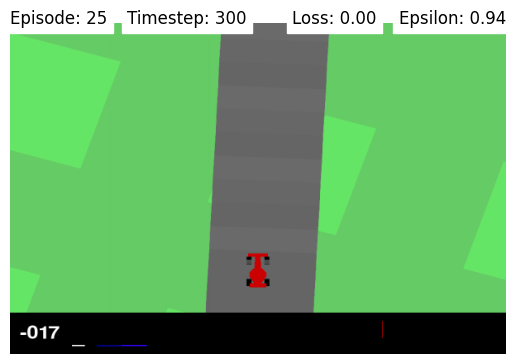

Traceback (most recent call last):
  File "C:\Users\Alexandre\AppData\Local\Temp\ipykernel_27944\1510050613.py", line 26, in <module>
    next_state, reward, done, truncated, _ = env.step(action_idx)
                                             ^^^^^^^^^^^^^^^^^^^^
  File "d:\Repo_Git\INF8225\.venv\Lib\site-packages\gymnasium\wrappers\common.py", line 125, in step
    observation, reward, terminated, truncated, info = self.env.step(action)
                                                       ^^^^^^^^^^^^^^^^^^^^^
  File "d:\Repo_Git\INF8225\.venv\Lib\site-packages\gymnasium\wrappers\common.py", line 393, in step
    return super().step(action)
           ^^^^^^^^^^^^^^^^^^^^
  File "d:\Repo_Git\INF8225\.venv\Lib\site-packages\gymnasium\core.py", line 327, in step
    return self.env.step(action)
           ^^^^^^^^^^^^^^^^^^^^^
  File "d:\Repo_Git\INF8225\.venv\Lib\site-packages\gymnasium\wrappers\common.py", line 285, in step
    return self.env.step(action)
           ^^^^^^^^^^^^^

current_reward,▇▅▅██▇▇▆▇▇▅▅▅█▇▇▆▇█▇▇█▇▄▇█▅█▅█▅▁█▇▇▇▆▇▇▆
done,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
episode,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
epsilon,█████▇▇▇▇▇▆▆▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▁▁▁▁▁
loss,▁▁▁▄▁▁▁▁▆▁▃▄▆▁▁▁▄▁▁▁▄▁▁▄▁█▁▁▁▁▁▃▁▁▁▁▁▁▃▄
reward,▄▇▇▇▆▁▅▇▇▆█▇▃▆▅▆▁█▇▇▆▇▆▇█
timestep,▃▁▂▁▂▁▂▂▆▇█▁▂▃▁▂▂▃▄▄▁▃▂▆▆▁▂▂▁▂▁▂▂▂▃▁▁▂▂▄
current_reward,-20.99929
done,0
episode,24
epsilon,0.93646


KeyboardInterrupt: 

In [ ]:
with wandb.init(
		config=config,
		project='INF8225 - TP4',
		group='DQN',
		save_code=True,
		mode="online"
	):
	# Training loop
	env = gym.make("CarRacing-v3", render_mode="rgb_array", domain_randomize=False, max_episode_steps=config["max_timesteps"], continuous=config["continuous"], lap_complete_percent=config["lap_complete_percent"])
	agent = DQNAgent(env, lr=config["lr"], gamma=config["gamma"], batch_size=config["batch_size"], memory_size=config["memory_size"], epsilon_start=config["epsilon_start"], epsilon_end=config["epsilon_end"], epsilon_decay=config["epsilon_decay"])
	
	if config["load_save"]:
		agent.load()
		
	successful_run = 0

	agent.policy_net.train()
	for ep in range(config["max_episodes"]):
		state, _ = env.reset(seed=config["seed"])
		state, _ = skip_zooming(env)
		state = transform(state)
		total_reward = 0
		rewards = []
		done = False
		t = 0

		while not done:
			action_idx, epsilon = agent.select_action(state)
			next_state, reward, done, truncated, _ = env.step(action_idx)
			done = done or truncated

			next_state = transform(next_state)

			agent.memory.append(state, action_idx, next_state, reward, done)
			rewards.append(reward)
			state = next_state
			total_reward += reward

			loss = agent.optimize_model()

			if t % 20 == 0:
				show_current_frame(env, {"Episode": ep, "Timestep": t, "Loss": loss, "Epsilon": epsilon})

			wandb.log({"current_reward": total_reward, "timestep": t, "loss": loss, "epsilon": epsilon})

			if (len(rewards) > config["max_losing_step"] and np.max(np.array(rewards[-config["max_losing_step"]:])) < 0):
				break

			t += 1

		if ep % config["target_update_freq"] == 0:
			agent.target_net.load_state_dict(agent.policy_net.state_dict())

		print(f"Episode {ep+1}, Total Reward: {total_reward}")
		image = wandb.Image(env.render(), caption=f"Episode {ep}")
		wandb.log({"episode": ep, "reward": total_reward, "image": image, "done": int(done) })
		
		if done == True:
			successful_run += 1

			if successful_run >= config["stop_criteria_count"]:
				break

		agent.save()
		
	env.close()

#### Car Racing Animation

In [ ]:
def run_agent_and_collect_frames(agent, env, seed=42):
  state, _ = env.reset(seed=seed)
  done = False
  frames = []

  while not done:
    frame = env.render()
    frames.append(frame)

    preprocessed_state = agent.preprocess_state(state)
    action = agent.select_action(preprocessed_state)
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    state = next_state

    return frames

# Function to display frames as an animation using matplotlib
def show_animation_frames(frames):
  fig = plt.figure(figsize=(7, 5))
  plt.axis('off')
  im = plt.imshow(frames[0])

  def animate(i):
    im.set_data(frames[i])
    return im,

  anim = animation.FuncAnimation(fig, animate, frames=len(frames), interval=50, repeat=False)
  plt.close(fig)
  display(HTML(anim.to_jshtml()))

# Run the episode with the trained agent
frames = run_agent_and_collect_frames(agent, env)

# Show the animation
show_animation_frames(frames)
